In [73]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime
import scipy.stats as stats
%matplotlib inline

In [74]:
#Create a for loop with a url query for 3 tickers to save daily open, close, ticker & date information. 
#Reorganize the columns

tickers = ["AAPL", "GOOG", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy.head())


  ticker     open    close           date
0   AAPL  20.8398  20.8793  1352091600000
1   AAPL  21.0796  20.8161  1352178000000
2   AAPL  20.4941  19.9286  1352264400000
3   AAPL  20.0225  19.2054  1352350800000
4   AAPL  19.3007  19.5379  1352437200000


In [75]:
#Print types
#dummy.info()
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')
dummy["date"] = pd.to_datetime(dummy["date"]).dt.date
#dummy.head()

In [76]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
goog_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOG"]
goog_daily2 = pd.DataFrame(goog_daily2)
#print(goog_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
goog_daily2.rename(columns = {'close':'GOOG'}, inplace = True)
del goog_daily2["ticker"]

#These are the actual stock price closes
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
goog_prices = goog_daily2.copy(deep=True)
#print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daily2.copy(deep=True)
goog_bch = goog_daily2.copy(deep=True)
#print(goog_bch)

#make copy for % changes
aapl_pctch = aapl_daily2.copy(deep=True)
amzn_pctch = amzn_daily2.copy(deep=True)
goog_pctch = goog_daily2.copy(deep=True)

#calculate % change
aapl_pctch["AAPL"]=aapl_pctch["AAPL"].pct_change()*100
amzn_pctch["AMZN"]=amzn_pctch["AMZN"].pct_change()*100
goog_pctch["GOOG"]=goog_pctch["GOOG"].pct_change()*100
aapl_daily2 = aapl_daily2[["date", "AAPL"]]

#calculate $ change
aapl_bch["AAPL"]=aapl_bch["AAPL"].diff()
amzn_bch["AMZN"]=amzn_bch["AMZN"].diff()
goog_bch["GOOG"]=goog_bch["GOOG"].diff()
#amzn_bch.head()
#print(aapl_prices)
#print(aapl_bch)

print(aapl_pctch)

          AAPL        date
0          NaN  2012-11-05
1    -0.302692  2012-11-06
2    -4.263527  2012-11-07
3    -3.628955  2012-11-08
4     1.731284  2012-11-09
...        ...         ...
2505  0.940945  2022-10-18
2506  0.076522  2022-10-19
2507 -0.326707  2022-10-20
2508  2.705907  2022-10-21
2509  1.480274  2022-10-24

[2510 rows x 2 columns]


In [77]:
#merge tables % change
merge_pctchange = aapl_pctch.merge(amzn_pctch, on='date', how='left')
merge_pctchange = merge_pctchange.merge(goog_pctch, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(goog_prices, on="date", how="left")

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(goog_bch, on="date", how="left")
merge_bch.head()

#reorder columns
merge_pctchange= merge_pctchange[['date','AAPL','GOOG', "AMZN"]]
merge_prices= merge_prices[['date','AAPL','GOOG', "AMZN"]]
merge_bch= merge_bch[['date','AAPL','GOOG', "AMZN"]]
#merge_bch
#merge_pctchange
#aapl_bch.head()

In [78]:

#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(100,200))
gs=plt.GridSpec(32,4, hspace=0.8, wspace = 0.3)
plt.rc('xtick', labelsize=70)
plt.rc('ytick', labelsize=70) 
#AAPL subplots

ax_aapl_bar_z=fig.add_subplot(gs[0:4, 0:2])
ax_aapl_bar_z.hist(aapl_bch["AAPL"], bins=10)
ax_aapl_bar_z.set_xlabel("AAPL Daily $ returns 2012-current", fontsize=80)

ax_hist_aapl_x=fig.add_subplot(gs[0:4,2:4])
ax_hist_aapl_x.hist(aapl_pctch["AAPL"], bins=10)
ax_hist_aapl_x.set_xlabel("AAPL Daily % Changes 2012-current", fontsize=80)

ax_hist_aapl_y=fig.add_subplot(gs[4:7,0:4])
ax_hist_aapl_y.hist(aapl_prices["AAPL"])
ax_hist_aapl_y.set_xlabel("AAPL Share Price 2012-current", fontsize = 80)

ax_scatter_aapl=fig.add_subplot(gs[7:11, 0:4])
ax_scatter_aapl.scatter(aapl_pctch["date"], aapl_pctch["AAPL"])
ax_scatter_aapl.set_xlabel("AAPL Daily % Returns 2012-current", fontsize = 80)

ax_scatter_aapl=fig.add_subplot(gs[11:15, 0:4])
ax_scatter_aapl.scatter(aapl_bch["date"], aapl_bch["AAPL"])
ax_scatter_aapl.set_xlabel("AAPL Daily $ Returns 2012-current", fontsize = 80)

#add AMZN subplots
#ax_amzn_bar=fig.add_subplot(gs[11:15, 0:4])
#ax_amzn_bar.bar(amzn_bch["date"], amzn_bch["AMZN"], align='center')
ax_hist_amzn_y=fig.add_subplot(gs[15:18,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[18:22, 0:3])
ax_scatter_amzn.scatter(amzn_pctch["date"], amzn_pctch["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[18:22,3])
ax_hist_amzn_x.hist(amzn_pctch["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_goog_bar=fig.add_subplot(gs[22:26, 0:4])
ax_goog_bar.bar(goog_bch["date"], goog_bch["GOOG"], align='center')
ax_hist_goog_y=fig.add_subplot(gs[26:29,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[29:33, 0:3])
ax_scatter_goog.scatter(goog_pctch["date"], goog_pctch["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[29:33,3])
ax_hist_goog_x.hist(goog_pctch["GOOG"], 40,orientation="horizontal")
plt.show()

C:\Users\lynds\anaconda3\envs\PythonData\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\lynds\anaconda3\envs\PythonData\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


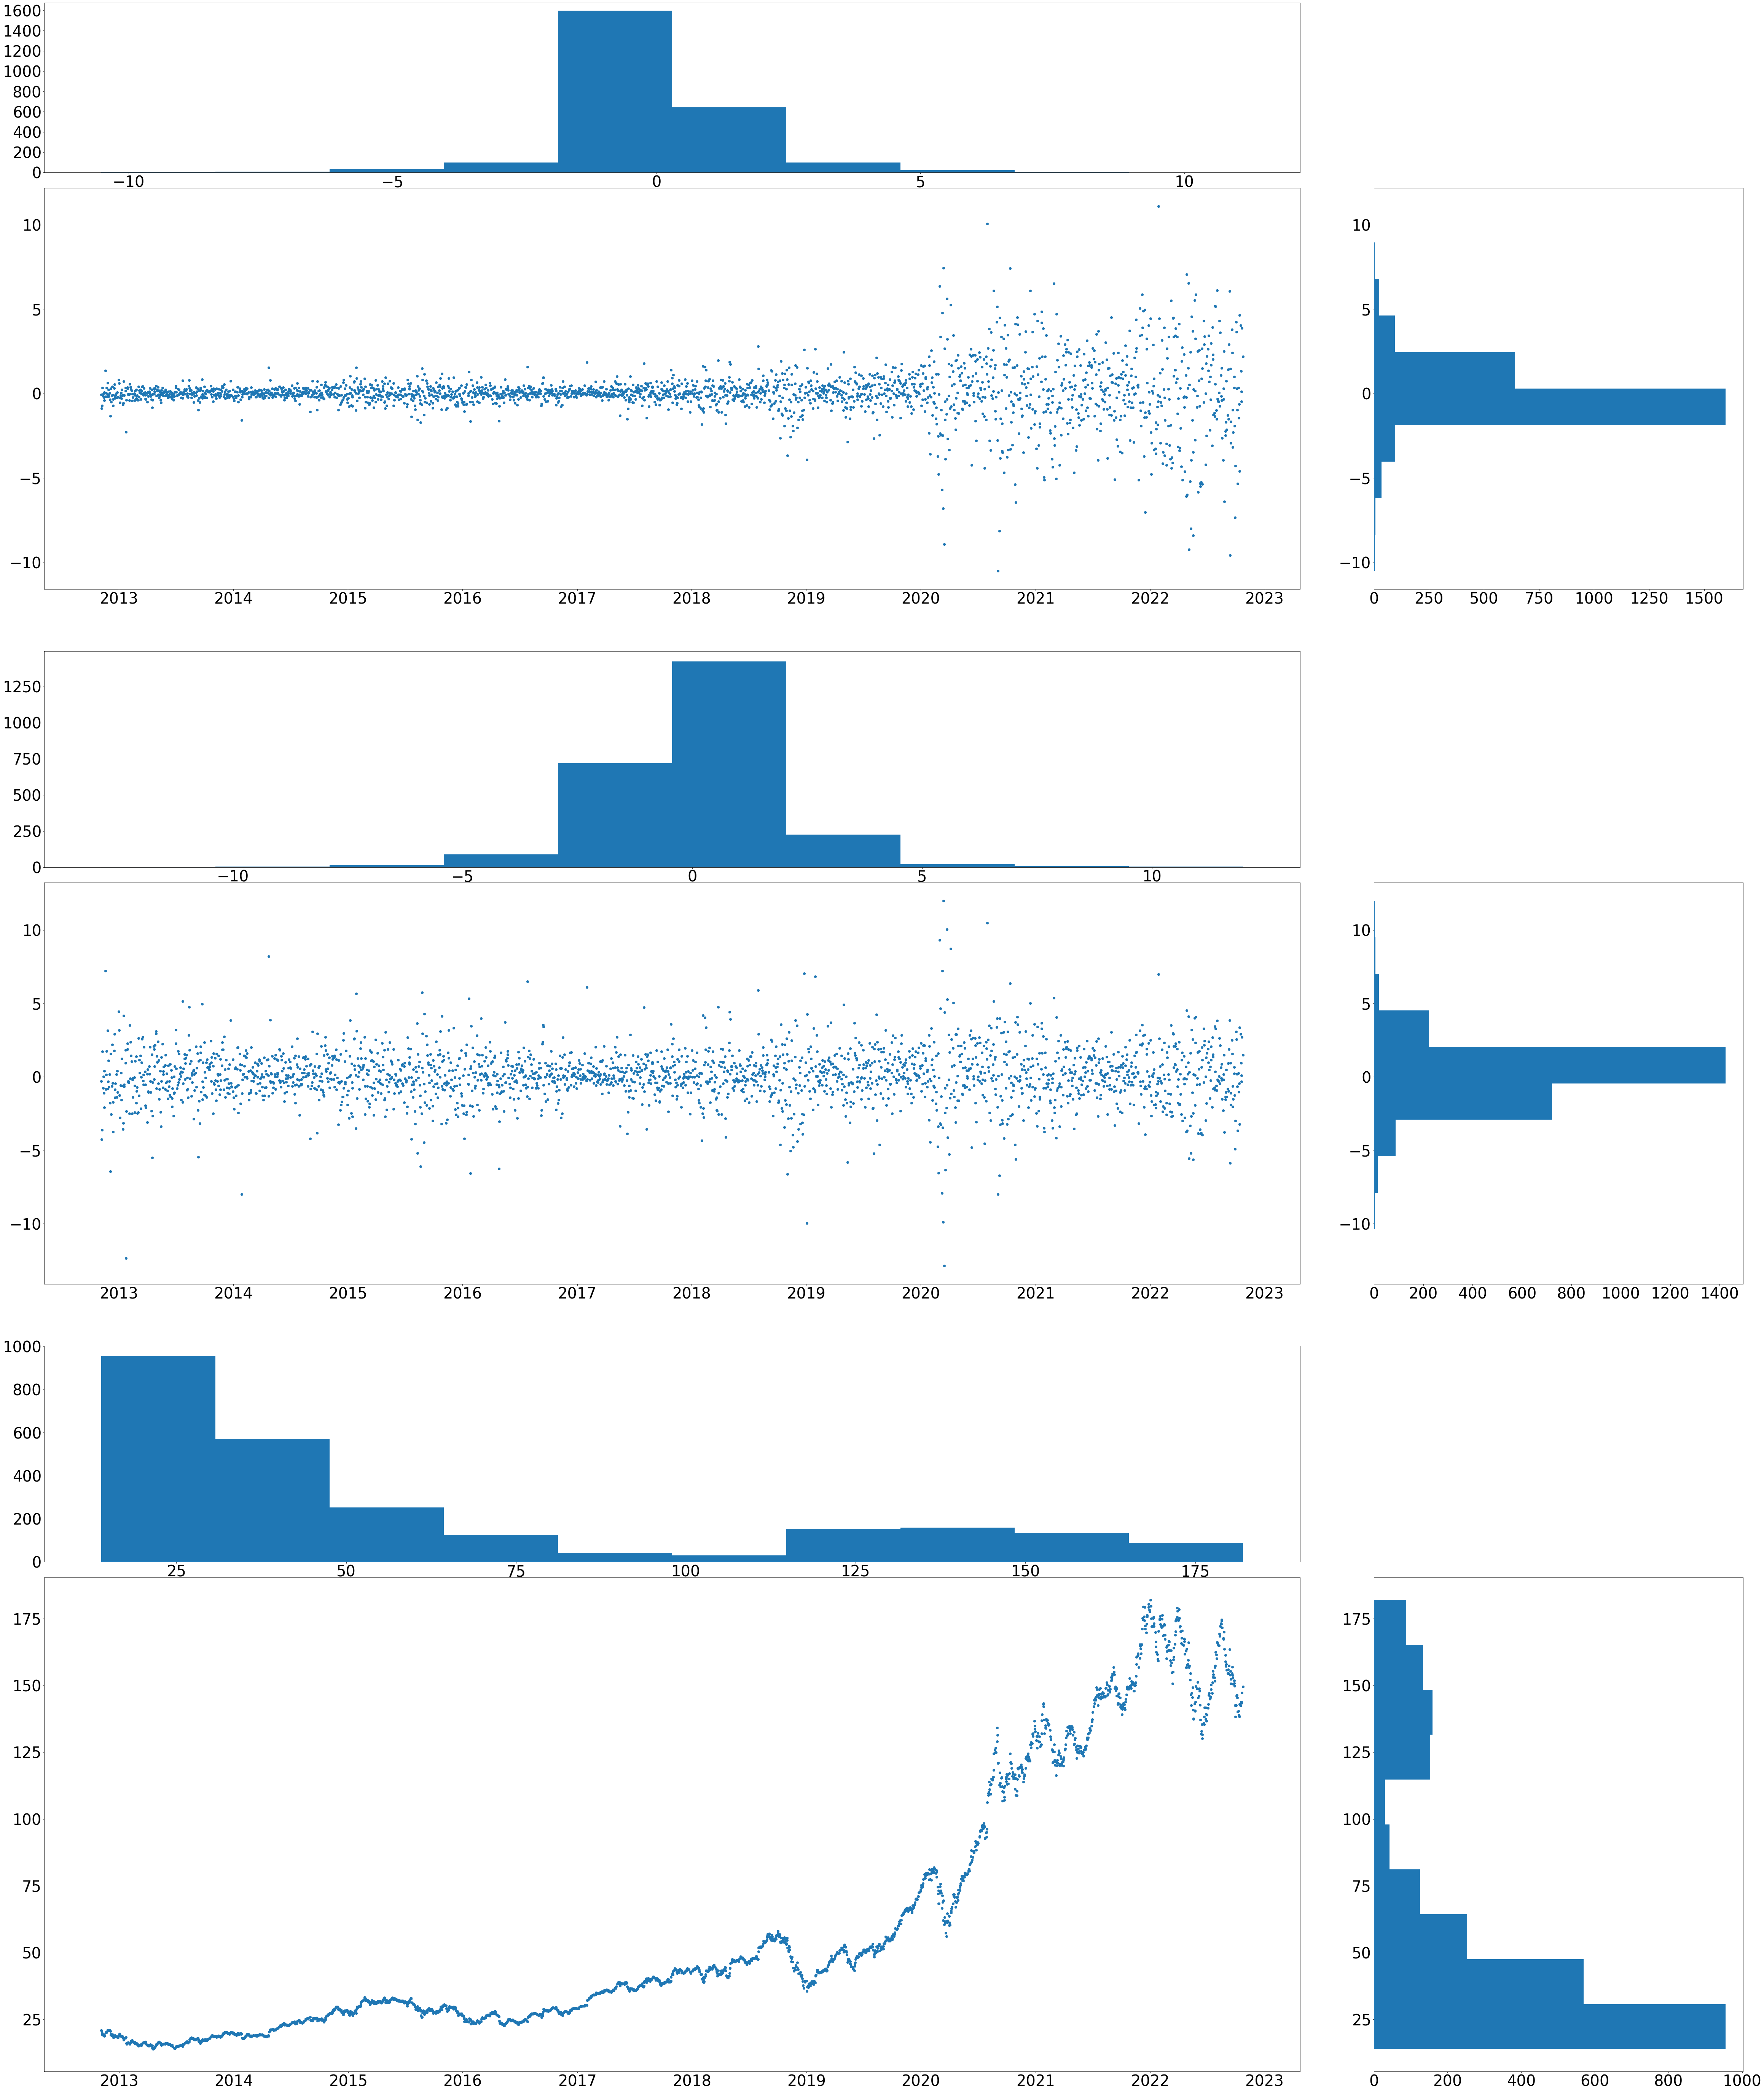

In [79]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(80,100))
gs=plt.GridSpec(45,4,hspace=0.5, wspace=0.2)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40) 
#AAPL subplots - basis points change comparison
ax_hist_aapl_y=fig.add_subplot(gs[0:4,0:3],  sharey=ax_hist_aapl_y)
ax_hist_aapl_y.hist(aapl_bch["AAPL"], bins=10)
ax_scatter_aapl=fig.add_subplot(gs[4:13, 0:3])
ax_scatter_aapl.scatter(aapl_bch["date"], aapl_bch["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[4:13,3])
ax_hist_aapl_x.hist(aapl_bch["AAPL"], orientation="horizontal")
#add AMZN subplots - closes comparison
ax_hist_amzn_y=fig.add_subplot(gs[14:19,0:3])
ax_hist_amzn_y.hist(aapl_pctch["AAPL"])
ax_scatter_amzn=fig.add_subplot(gs[19:28, 0:3])
ax_scatter_amzn.scatter(aapl_pctch["date"], aapl_pctch["AAPL"])
ax_hist_amzn_x=fig.add_subplot(gs[19:28,3])
ax_hist_amzn_x.hist(aapl_pctch["AAPL"], orientation="horizontal")
#add GOOGL subplots

ax_hist_goog_y=fig.add_subplot(gs[29:34,0:3])
ax_hist_goog_y.hist(aapl_prices["AAPL"])
ax_scatter_goog=fig.add_subplot(gs[34:45, 0:3])
ax_scatter_goog.scatter(aapl_prices["date"], aapl_prices["AAPL"])
ax_hist_goog_x=fig.add_subplot(gs[34:45,3])
ax_hist_goog_x.hist(aapl_prices["AAPL"],orientation="horizontal")
plt.show()

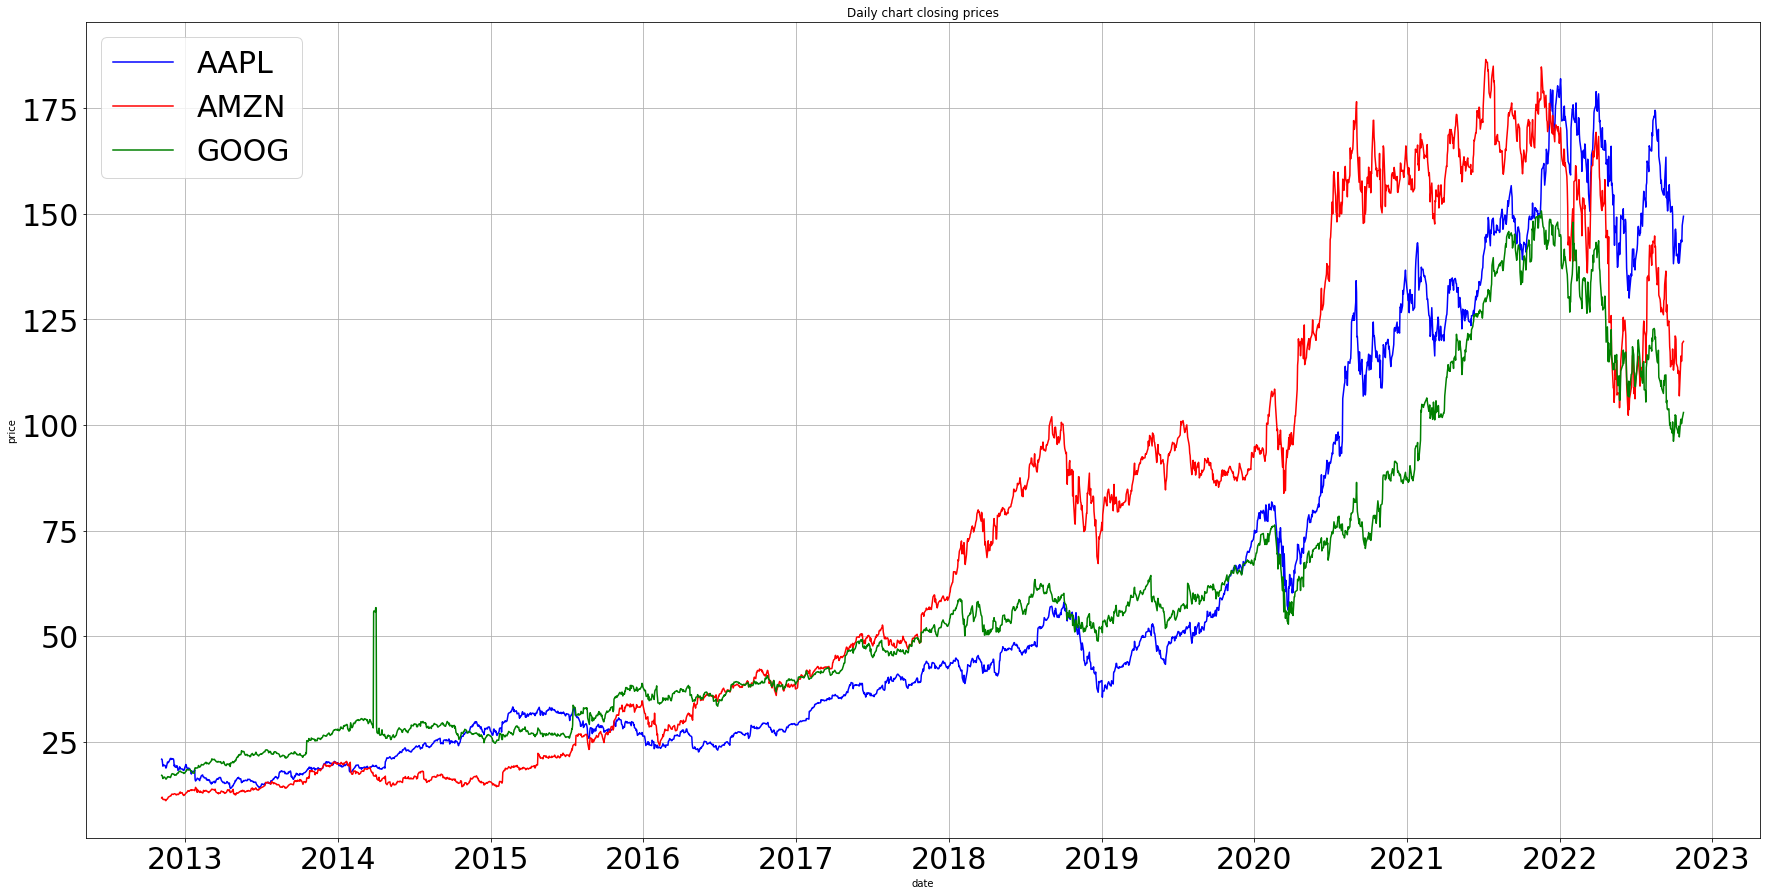

In [80]:
plt.figure(figsize=(30,15))
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)

aapl_daily_chart, = plt.plot(merge_prices["date"], merge_prices["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_prices["date"], merge_prices["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_prices["date"], merge_prices["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")

In [81]:
tickers_ratios = pd.DataFrame(columns = ["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"])
tickers3 = ["AAPL", "GOOG", "AMZN"]
prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/ratios/{name}?period=quarter&limit=43&apikey={prep_key}"
    ratios_response = requests.get(query_url).json()
    tickers_ratio_response = pd.json_normalize(ratios_response)
    tickers_ratio_response["symbol"] = name
    tickers_ratio_response = tickers_ratio_response[["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"]]
    tickers_ratios= pd.concat([tickers_ratios,tickers_ratio_response])
tickers_ratios.columns=["Date", "Ticker", "Period", "PE", "PEG"]
#print(tickers_ratios)

#Create copy that won't affect original
ticker_ratios = tickers_ratios.copy(deep=True)
#print(fiscal_qbs)

#Create separate dataframe based on symbols
aapl_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AAPL"]
aapl_ratios = pd.DataFrame(aapl_ratios)
aapl_ratios =aapl_ratios.sort_values("Date", ascending=True)

amzn_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AMZN"]
amzn_ratios = pd.DataFrame(amzn_ratios)

goog_ratios = ticker_ratios[ticker_ratios["Ticker"] == "GOOG"]
goog_ratios = pd.DataFrame(goog_ratios)
#goog_ratios.head()
aapl_ratios.tail()

,Date,Ticker,Period,PE,PEG
4,2021-09-25,AAPL,Q4,29.466787,-6.433582
3,2021-12-25,AAPL,Q1,21.339298,0.310164
2,2022-03-26,AAPL,Q2,28.628169,-1.041473
1,2022-06-25,AAPL,Q3,29.441966,-1.365037
0,2022-09-24,AAPL,Q4,29.094279,3.879237


In [82]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_qis = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "eps"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/income-statement/{name}?period=quarter&limit=43&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_yearqis = pd.json_normalize(fiscal_response)
    fiscal_yearqis["symbol"] = name
    fiscal_yearqis = fiscal_yearqis[["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "eps"]]
    dum_fiscal_qis= pd.concat([dum_fiscal_qis,fiscal_yearqis])
dum_fiscal_qis.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", "EPS"]
#print(dum_fiscal_yearqis)
#Create copy that won't affect original
fiscal_yearsqis = dum_fiscal_qis.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "AAPL"]
aapl_qis = pd.DataFrame(aapl_qis)
#print(aapl_fiscal_year.head())
amzn_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "AMZN"]
amzn_qis = pd.DataFrame(amzn_qis)
#print(amzn_fiscal_year.head())
goog_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "GOOG"]
goog_qis = pd.DataFrame(goog_qis)
#fiscal_yearsqis
quarterly_pe_eps = fiscal_yearsqis.merge(ticker_ratios, on=["Date", "Ticker"], how='left')
del quarterly_pe_eps["Period_y"]
del quarterly_pe_eps["Filing Date"]
quarterly_pe_eps.rename(columns = {'Period_x':'Period'}, inplace = True)
quarterly_pe_eps['Date'] = pd.to_datetime(quarterly_pe_eps['Date'])
aapl_pe_eps = quarterly_pe_eps[quarterly_pe_eps["Ticker"] == "AAPL"]
aapl_pe_eps = pd.DataFrame(aapl_pe_eps)
amzn_pe_eps = quarterly_pe_eps[quarterly_pe_eps["Ticker"] == "AMZN"]
amzn_pe_eps = pd.DataFrame(amzn_pe_eps)
goog_pe_eps = quarterly_pe_eps[quarterly_pe_eps["Ticker"] == "GOOG"]
goog_pe_eps = pd.DataFrame(goog_pe_eps)
#quarterly_pe_eps.info()
goog_pe_eps.head()

,Date,Ticker,Fiscal Year,Period,EPS,PE,PEG
43,2022-09-30,GOOG,2022,Q3,1.070000,22.496059,-1.829679
44,2022-06-30,GOOG,2022,Q2,1.220001,22.440763,-24.962599
45,2022-03-31,GOOG,2022,Q1,1.245001,28.045909,-1.417429
46,2021-12-31,GOOG,2021,Q4,1.557501,23.222970,2.403562
47,2021-09-30,GOOG,2021,Q3,1.422001,23.426947,8.722001


In [83]:
goog_pe_eps['Date'] = pd.to_datetime(goog_pe_eps['Date'])
plt.barh(goog_pe_eps["PE"], goog_pe_eps["Date"], color="blue")
plt.barh(goog_pe_eps["EPS"], goog_pe_eps["Date"], color="orange")
plt.show()

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [84]:
#Convert date in dataframes to datetime
aapl_ratios['Date'] = pd.to_datetime(aapl_ratios['Date'])
merge_prices['date'] = pd.to_datetime(merge_prices['date'])
goog_ratios['Date'] = pd.to_datetime(goog_ratios['Date'])
amzn_ratios['Date'] = pd.to_datetime(amzn_ratios['Date'])
#amzn_ratios

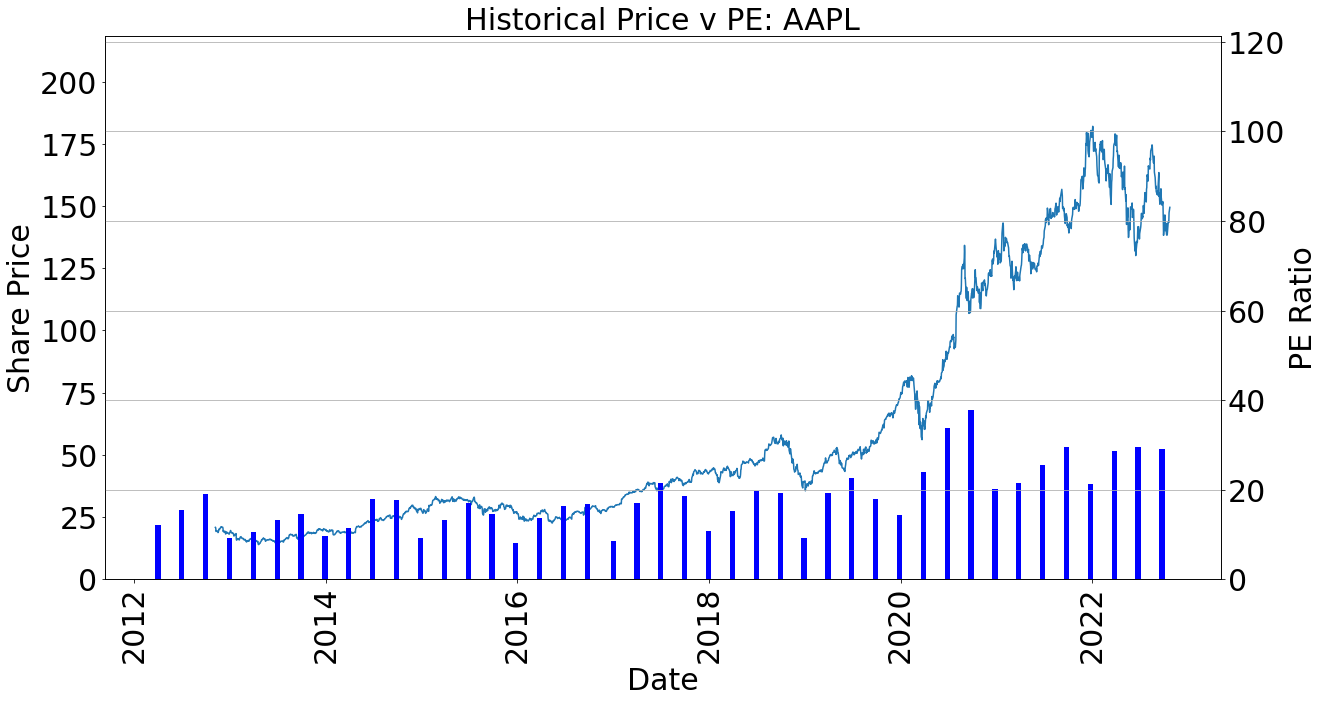

In [85]:
fig = plt.figure(figsize=(20,10))
ax1=plt.subplot(1,1,1)
ax1.plot(merge_prices["date"], merge_prices["AAPL"])
ax1.set_ylim(0,merge_prices["AAPL"].max()*1.2)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(90)
ax2=ax1.twinx()
ax2.bar(aapl_ratios["Date"], aapl_ratios["PE"], width=20, color="b")
ax2.set_ylim(0,merge_prices["AAPL"].max()/1.5)

plt.title("Historical Price v PE: AAPL", fontsize="30")
ax1.set_xlabel("Date", fontsize="30")
ax1.set_ylabel("Share Price", fontsize="30")
ax2.set_ylabel("PE Ratio", fontsize="30")

plt.grid()

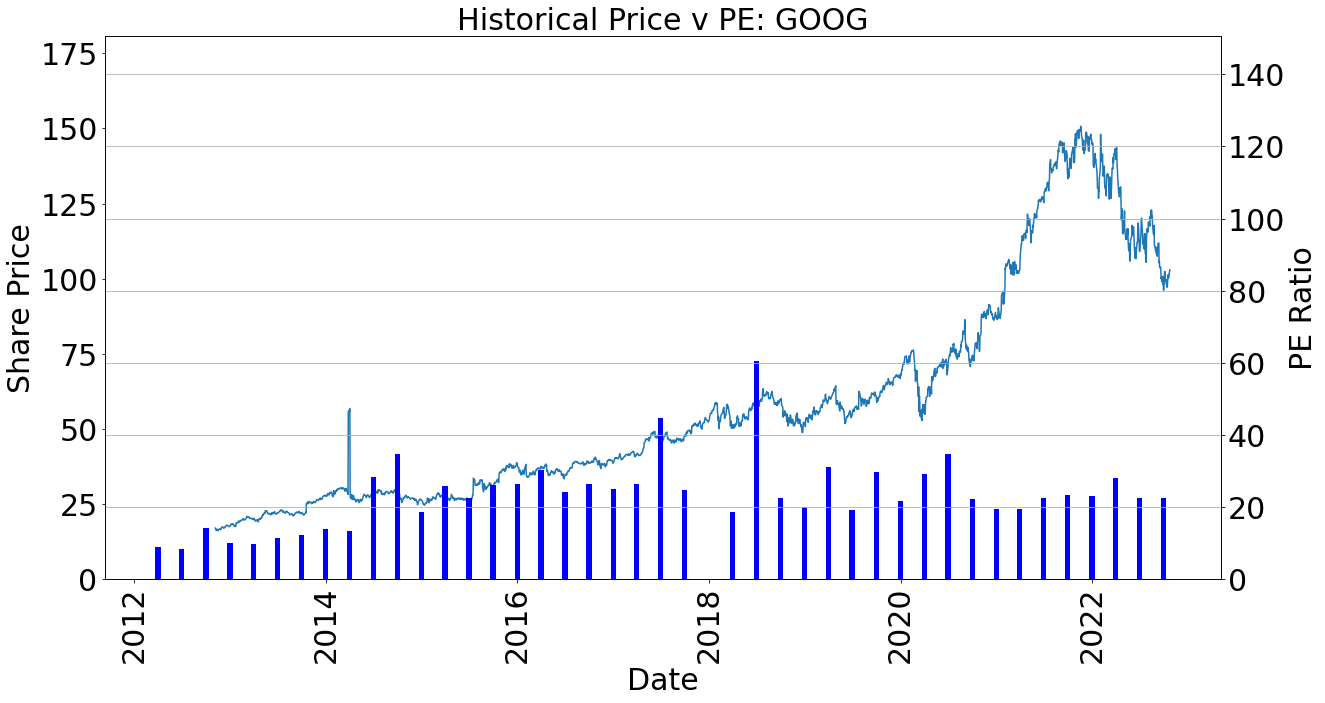

In [86]:
fig = plt.figure(figsize=(20,10))
ax1=plt.subplot(1,1,1)
ax1.plot(merge_prices["date"], merge_prices["GOOG"])
ax1.set_ylim(0,merge_prices["GOOG"].max()*1.2)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(90)
ax2=ax1.twinx()
ax2.bar(goog_ratios["Date"], goog_ratios["PE"], width=20, color="b")
ax2.set_ylim(0,merge_prices["GOOG"].max())

plt.title("Historical Price v PE: GOOG", fontsize="30")
ax1.set_xlabel("Date", fontsize="30")
ax1.set_ylabel("Share Price", fontsize="30")
ax2.set_ylabel("PE Ratio", fontsize="30")

plt.grid()

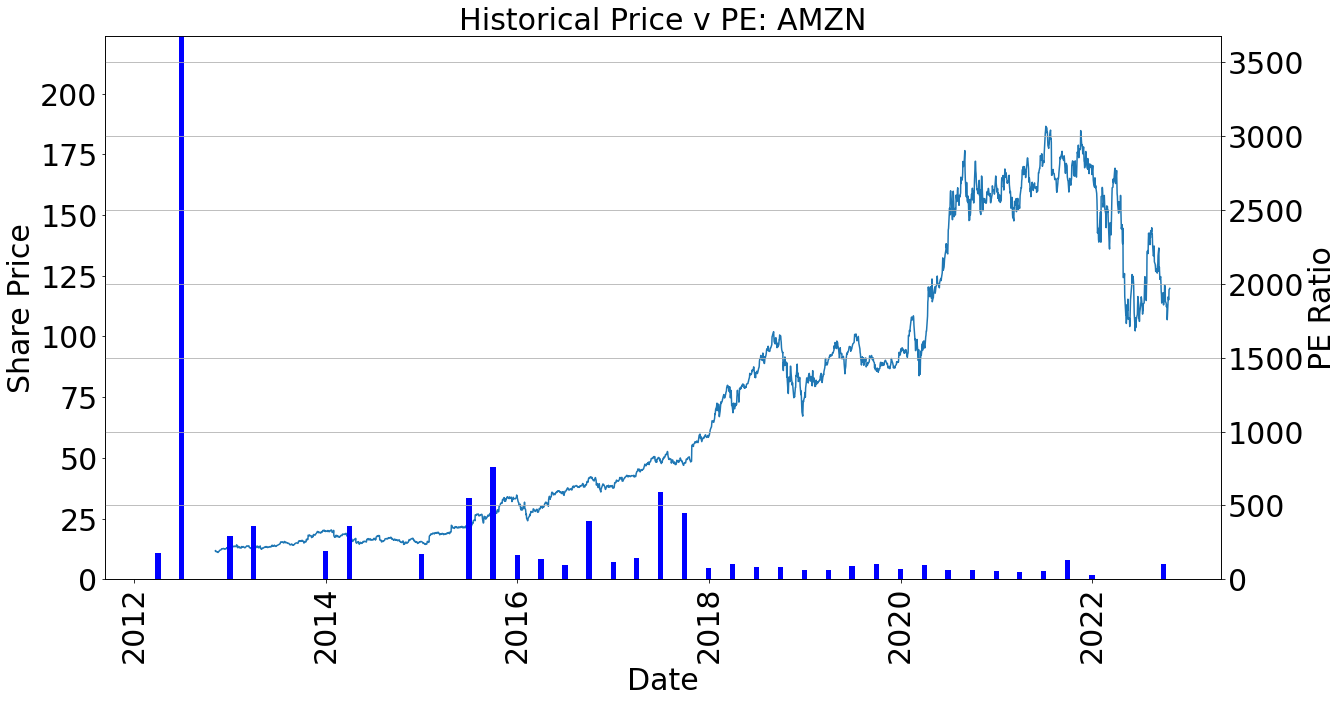

In [87]:
fig = plt.figure(figsize=(20,10))
ax1=plt.subplot(1,1,1)
ax1.plot(merge_prices["date"], merge_prices["AMZN"])
ax1.set_ylim(0,merge_prices["AMZN"].max()*1.2)

for xlabel in ax1.get_xticklabels():
    xlabel.set_rotation(90)
ax2=ax1.twinx()
ax2.bar(amzn_ratios["Date"], amzn_ratios["PE"], width=20, color="b")
ax2.set_ylim(0,amzn_ratios["PE"].max())

plt.title("Historical Price v PE: AMZN", fontsize="30")
ax1.set_xlabel("Date", fontsize="30")
ax1.set_ylabel("Share Price", fontsize="30")
ax2.set_ylabel("PE Ratio", fontsize="30")

plt.grid()

In [88]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_year_is = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "revenue", "grossProfit", "netIncome", 
                                          "eps", "weightedAverageShsOut"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/income-statement/{name}?limit=12&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_year_is = pd.json_normalize(fiscal_response)
    fiscal_year_is["symbol"] = name
    fiscal_year_is = fiscal_year_is[["date", "symbol", "fillingDate", "calendarYear", 
                                "period", "revenue", "grossProfit", "netIncome", 
                                "eps", "weightedAverageShsOut"]]
    dum_fiscal_year_is= pd.concat([dum_fiscal_year_is,fiscal_year_is])
dum_fiscal_year_is.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Revenue", "Gross Profit", "Net Income", "EPS", "Shares Outstanding"]
#print(dum_fiscal_year_is)
#Create copy that won't affect original
fiscal_years_is = dum_fiscal_year_is.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "AAPL"]
aapl_yis = pd.DataFrame(aapl_yis)
#print(aapl_fiscal_year.head())
amzn_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "AMZN"]
amzn_yis = pd.DataFrame(amzn_yis)
#print(amzn_fiscal_year.head())
goog_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "GOOG"]
goog_yis = pd.DataFrame(goog_yis)
goog_yis.tail()

,Date,Ticker,Filing Date,Fiscal Year,Period,Revenue,Gross Profit,Net Income,EPS,Shares Outstanding
7,2014-12-31,GOOG,2014-12-31,2014,FY,66001000000,40310000000,14444000000,1.068500,13518694592
8,2013-12-31,GOOG,2013-12-31,2013,FY,59825000000,33967000000,12920000000,1.941001,6656917337
9,2012-12-31,GOOG,2012-12-31,2012,FY,50175000000,29541000000,10737000000,1.640501,6544257382
10,2011-12-31,GOOG,2011-12-31,2011,FY,37905000000,24717000000,9737000000,1.508501,6455557417
11,2010-12-31,GOOG,2010-12-31,2010,FY,29321000000,18904000000,8505000000,1.334501,6374037450


In [89]:
#Create copy to rename columns to create boxplot for Anova calculation

aapl_box = aapl_yis.copy(deep=True)
amzn_box = amzn_yis.copy(deep=True)
goog_box = goog_yis.copy(deep=True)
aapl_box.rename(columns = {'Revenue':'AAPL Rev'}, inplace = True)
aapl_box.rename(columns = {'Net Income':'AAPL Net Income'}, inplace = True)
amzn_box.rename(columns = {'Revenue':'AMZN Rev'}, inplace = True)
amzn_box.rename(columns = {'Net Income':'AMZN Net Income'}, inplace = True)
goog_box.rename(columns = {'Revenue':'GOOG Rev'}, inplace = True)
goog_box.rename(columns = {'Net Income':'GOOG Net Income'}, inplace = True)
#aapl_box
aapl_box.drop([ "Date", "Period", "Filing Date", "Ticker", "Gross Profit", "EPS", "Shares Outstanding"], 1, inplace=True)
amzn_box.drop([ "Date", "Period", "Filing Date", "Ticker", "Gross Profit", "EPS", "Shares Outstanding"], 1, inplace=True)
goog_box.drop([ "Date", "Period", "Filing Date", "Ticker", "Gross Profit", "EPS", "Shares Outstanding"], 1, inplace=True)
amzn_box.head()

,Fiscal Year,AMZN Rev,AMZN Net Income
0,2021,469822000000,33364000000
1,2020,386064000000,21331000000
2,2019,280522000000,11588000000
3,2018,232887000000,10073000000
4,2017,177866000000,3033000000


In [96]:
#Merge dataframes: one for revenue & one for net income 
box_plot_merge = aapl_box.merge(amzn_box, on="Fiscal Year", how='left')
box_plot_merge = box_plot_merge.merge(goog_box, on="Fiscal Year", how="left")
box_plot_rev = box_plot_merge.copy(deep=True)
#Drop columns not needed in datafrane
box_plot_rev.drop([ "AMZN Net Income", "AAPL Net Income", "GOOG Net Income"], 1, inplace=True)
box_plot_merge.drop([ "AAPL Rev", "AMZN Rev", "GOOG Rev"], 1, inplace=True)
#Drop NaN values
box_plot_merge = box_plot_merge.dropna()
box_plot_rev = box_plot_rev.dropna()
#Copy box plots to try second box plot code 
box_plot_rev2 = box_plot_rev.copy(deep=True)
box_plot_merge2 = box_plot_merge.copy(deep=True)
print(box_plot_rev)
print(box_plot_merge)

#Redo the format of the boxplot dataframes to better fit the boxplot info
box_plot_merge = pd.melt(box_plot_merge, id_vars='Fiscal Year', value_vars=['AAPL Net Income', 'AMZN Net Income', 'GOOG Net Income'])
box_plot_rev=pd.melt(box_plot_rev, id_vars="Fiscal Year", value_vars=["AAPL Rev", "AMZN Rev","GOOG Rev"])
print(box_plot_rev.head())
print(box_plot_merge.head())

   Fiscal Year      AAPL Rev      AMZN Rev      GOOG Rev
1         2021  365817000000  469822000000  257637000000
2         2020  274515000000  386064000000  182527000000
3         2019  260174000000  280522000000  161857000000
4         2018  265595000000  232887000000  136819000000
5         2017  229234000000  177866000000  110855000000
6         2016  215639000000  135987000000   90272000000
7         2015  233715000000  107006000000   74989000000
8         2014  182795000000   88988000000   66001000000
9         2013  170910000000   74452000000   59825000000
10        2012  156508000000   61093000000   50175000000
11        2011  108249000000   48077000000   37905000000
   Fiscal Year AAPL Net Income AMZN Net Income GOOG Net Income
1         2021     94680000000     33364000000     76033000000
2         2020     57411000000     21331000000     40269000000
3         2019     55256000000     11588000000     34343000000
4         2018     59531000000     10073000000     30736000000
5

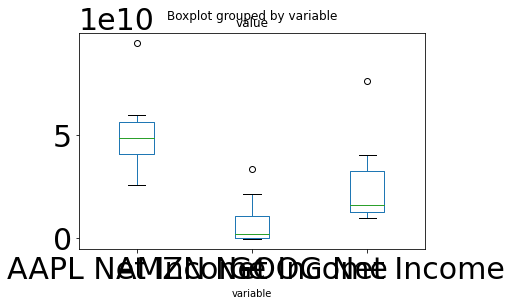

In [97]:
#Create boxplot for Net Income 
box_plot_merge.boxplot(by ='variable', column =['value'], grid = False)

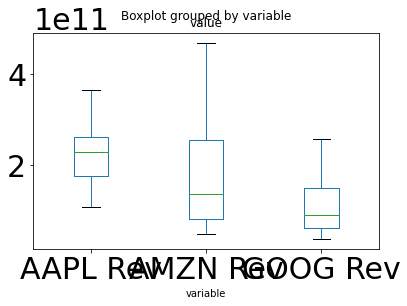

In [98]:
#Create boxplot for Revenue
box_plot_rev.boxplot(by ='variable', column =['value'], grid = False)

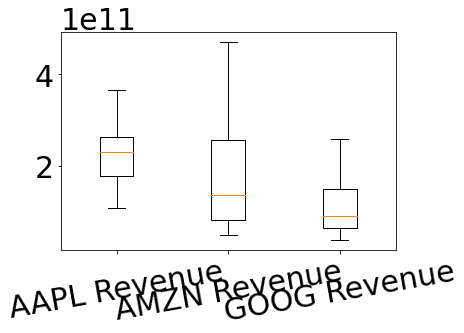

In [99]:
aapl_rev = box_plot_rev2["AAPL Rev"]
amzn_rev = box_plot_rev2["AMZN Rev"]
goog_rev = box_plot_rev2["GOOG Rev"]
columns = [aapl_rev, amzn_rev, goog_rev]
fig, ax = plt.subplots()
ax.boxplot(columns)
plt.xticks([1, 2, 3], ["AAPL Revenue", "AMZN Revenue", "GOOG Revenue"], rotation=10)
plt.show()


In [71]:
#Extract individual revenues
aapl_rev = box_plot_rev[box_plot_rev["variable"] == "AAPL Rev"]["value"]
amzn_rev = box_plot_rev[box_plot_rev["variable"] == "AMZN Rev"]["value"]
goog_rev = box_plot_rev[box_plot_rev["variable"] == "GOOG Rev"]["value"]
#calculate anova for Revenue
stats.f_oneway(aapl_rev, amzn_rev, goog_rev)

F_onewayResult(statistic=4.516061880858602, pvalue=0.019000825922677406)

In [13]:
#Extract individual revenues
aapl_net = box_plot_merge[box_plot_merge["variable"] == "AAPL Net Income"]["value"]
amzn_net = box_plot_merge[box_plot_merge["variable"] == "AMZN Net Income"]["value"]
goog_net = box_plot_merge[box_plot_merge["variable"] == "GOOG Net Income"]["value"]
#calculate anova for Revenue
stats.f_oneway(aapl_net, amzn_net, goog_net)

F_onewayResult(statistic=19.638264149500845, pvalue=3.094187452296735e-06)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026754E31908>,
      dtype=object)

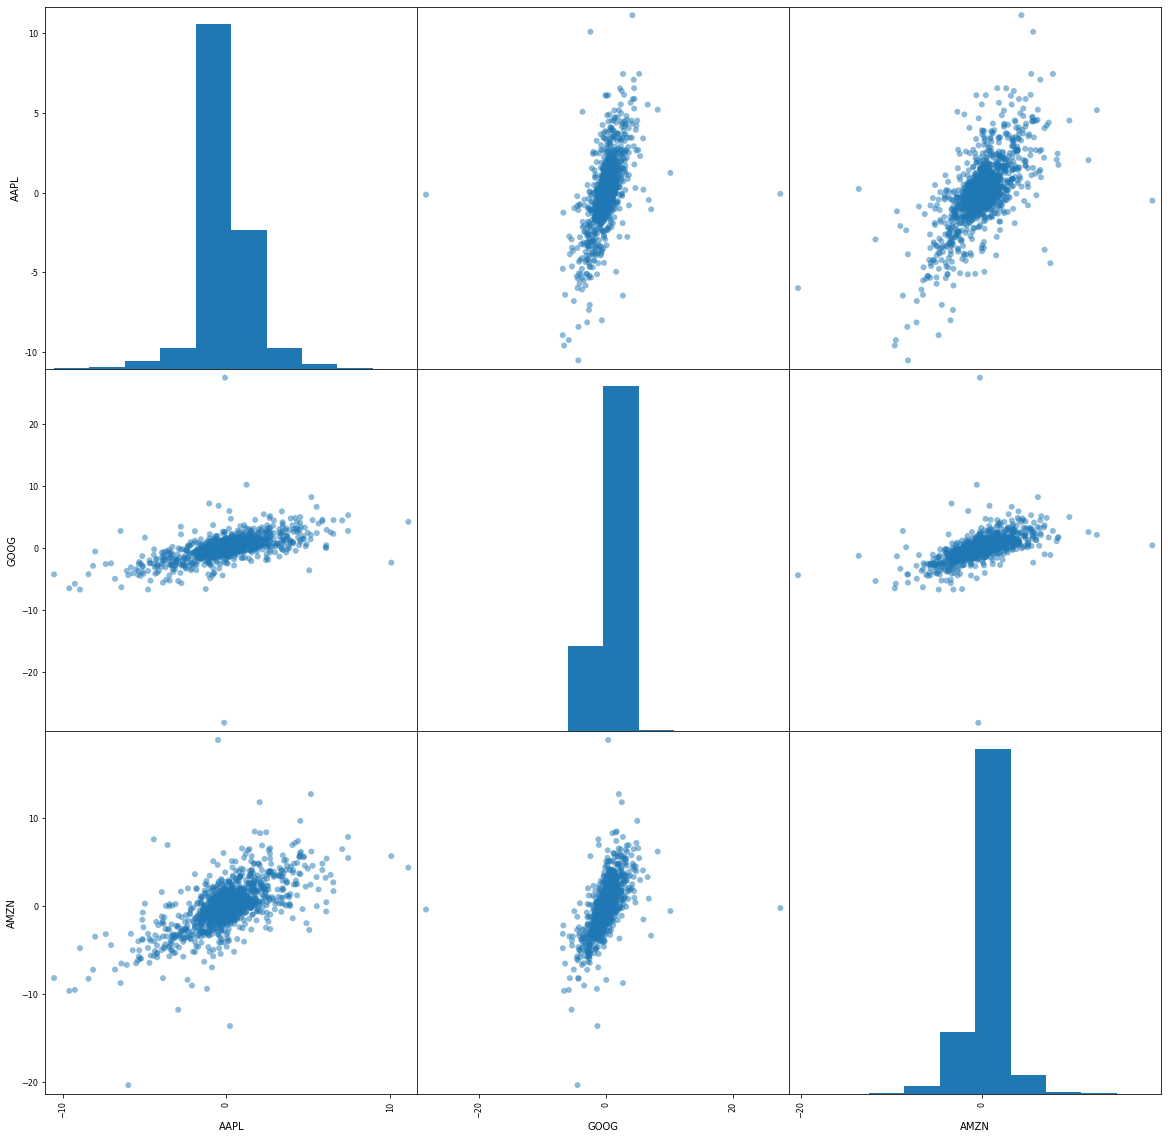

In [100]:
#Create scatter matrix of daily returns by percent

stocks_corr = merge_pctchange.corr()
stocks_corr
pd.plotting.scatter_matrix(merge_bch,figsize=(20,20),grid=True,
                           marker='o')

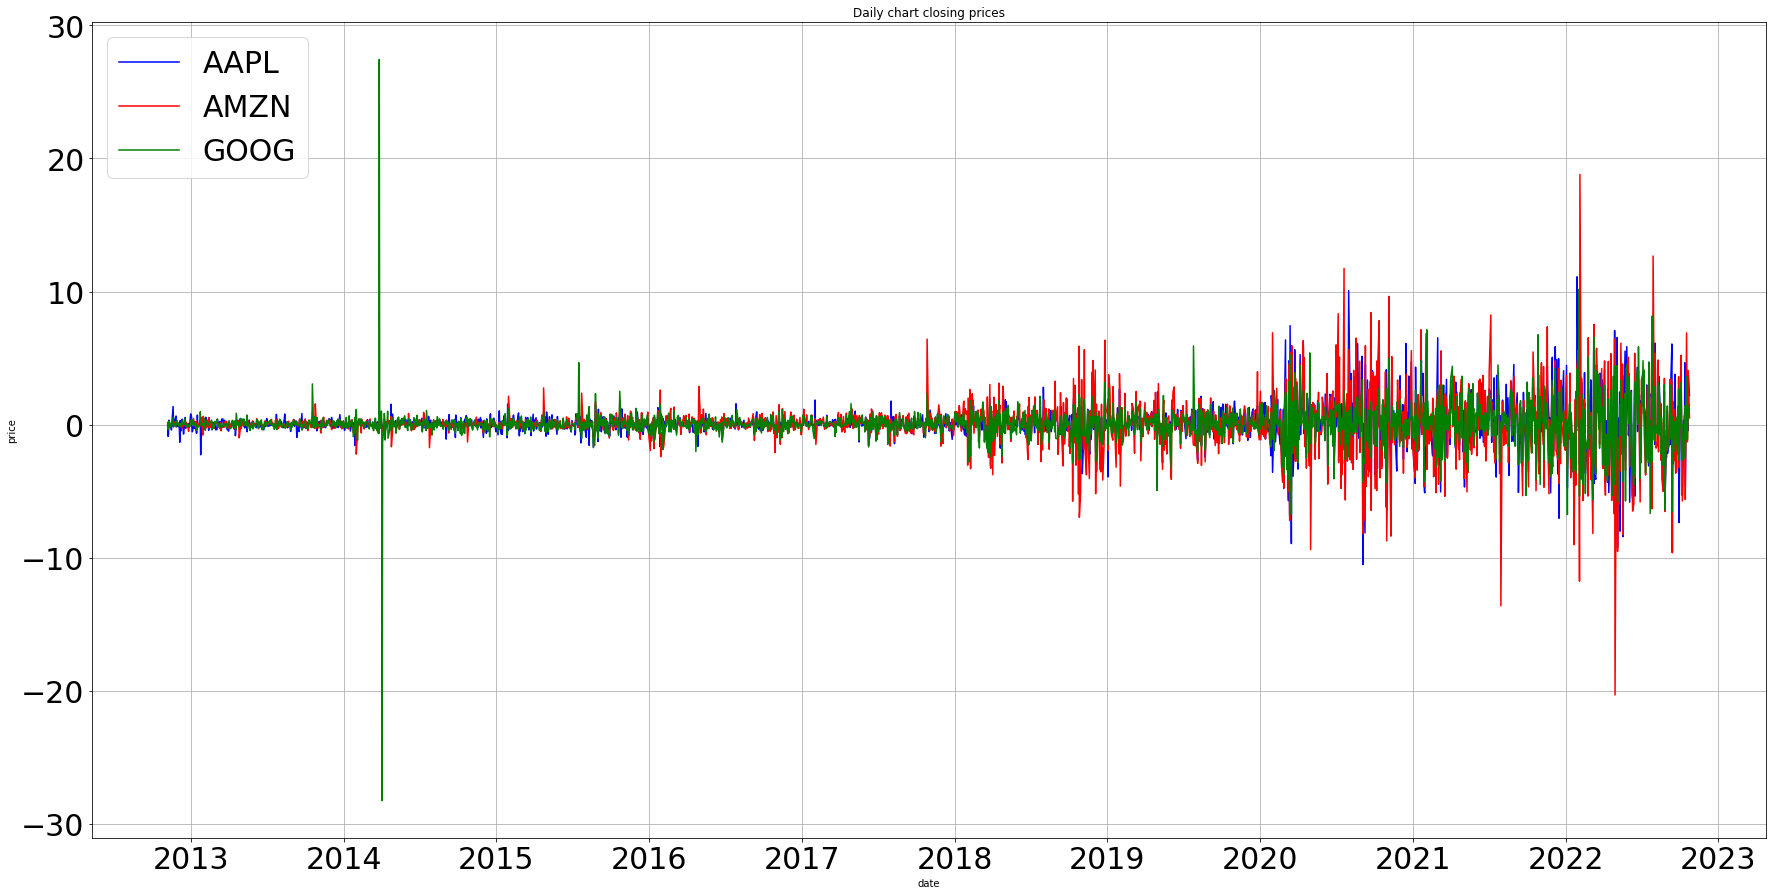

In [101]:
plt.figure(figsize=(30,15))
aapl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")

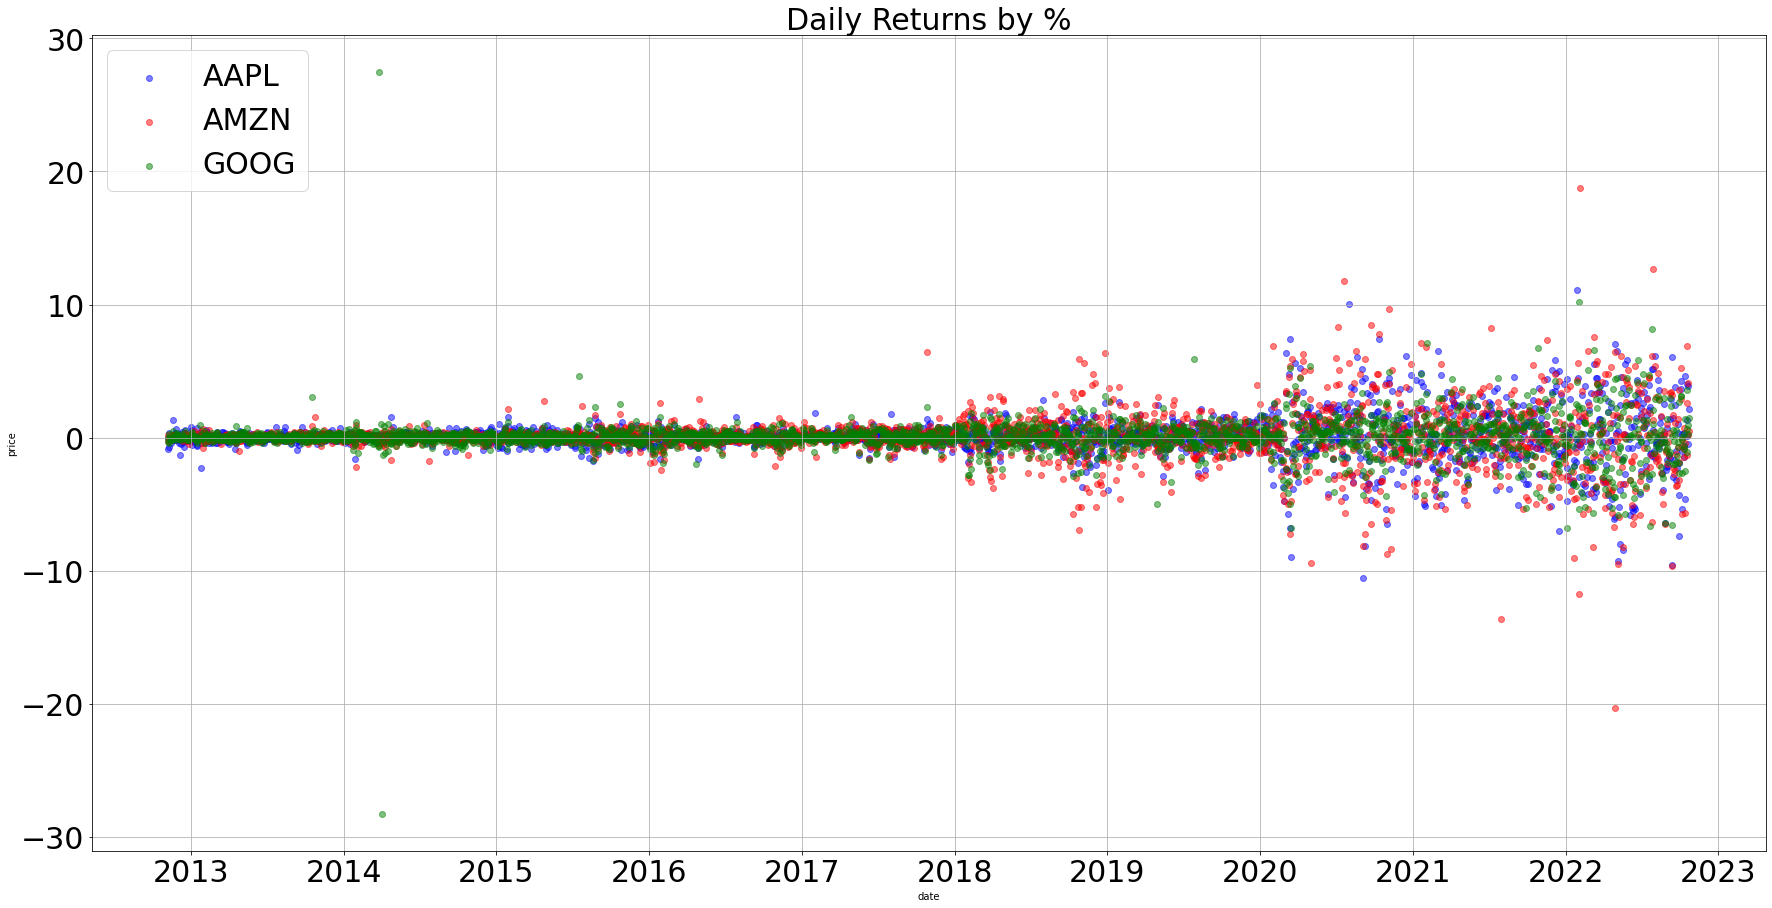

In [102]:
#Create scatterplot of all 3 stocks by daily % change
plt.figure(figsize=(30,15))
plt.scatter(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL", alpha = .5)
plt.scatter(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN",  alpha = .5)
plt.scatter(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG",  alpha = .5)
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily Returns by %", fontsize = 30)
plt.legend(fontsize = "30",loc="upper left")